In [277]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from scipy.optimize import minimize
import math
import pandas as pd
from scipy.spatial import KDTree
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline

In [446]:
# load image and convert to HSV
original_img = cv2.imread("data/camera 71/2022_12_15_15_51_19_944_rgb.png")
original_img2 = cv2.imread("data/camera 72/2022_12_15_15_51_19_956_rgb.png")
original_img3 = cv2.imread("data/camera 73/2022_12_15_15_51_19_934_rgb.png")
# original_img4 = cv2.imread("data/camera 74/2022_12_15_15_51_19_951_rgb.png")
original_img4 = cv2.imread("data/camera 11/2022_12_15_15_51_19_927_rgb_left.png")


hsv_original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
hsv_original_img2 = cv2.cvtColor(original_img2, cv2.COLOR_BGR2HSV)
hsv_original_img3 = cv2.cvtColor(original_img3, cv2.COLOR_BGR2HSV)
hsv_original_img4 = cv2.cvtColor(original_img4, cv2.COLOR_BGR2HSV)

In [447]:
def plot_mask(h1, s1, v1, h2, s2, v2):
    mask = cv2.inRange(hsv_original_img, (h1, s1, v1), (h2, s2, v2))
    mask2 = cv2.inRange(hsv_original_img2, (h1, s1, v1), (h2, s2, v2))
    mask3 = cv2.inRange(hsv_original_img3, (h1, s1, v1), (h2, s2, v2))
    mask4 = cv2.inRange(hsv_original_img4, (h1, s1, v1), (h2, s2, v2))

    plt.figure(figsize=(18, 24))
    
    plt.subplot(4, 2, 1)
    plt.imshow(mask)
    plt.subplot(4, 2, 2)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    
    # plt.subplot(4, 2, 3)
    # plt.imshow(mask2)
    # plt.subplot(4, 2, 4)
    # plt.imshow(cv2.cvtColor(original_img2, cv2.COLOR_BGR2RGB))
    
#     plt.subplot(4, 2, 5)
#     plt.imshow(mask3)
#     plt.subplot(4, 2, 6)
#     plt.imshow(cv2.cvtColor(original_img3, cv2.COLOR_BGR2RGB))
    
    # plt.subplot(4, 2, 7)
    # plt.imshow(mask4)
    # plt.subplot(4, 2, 8)
    # plt.imshow(cv2.cvtColor(original_img4, cv2.COLOR_BGR2RGB))
    
    plt.show()

In [448]:
interact(
    plot_mask,
    h1=FloatSlider(min=0, max=180, step=1, value=55),
    s1=FloatSlider(min=0, max=255, step=1, value=33),
    v1=FloatSlider(min=0, max=255, step=1, value=33),
    h2=FloatSlider(min=0, max=180, step=1, value=85),
    s2=FloatSlider(min=0, max=255, step=1, value=255),
    v2=FloatSlider(min=0, max=255, step=1, value=255),
)
# HSL (0-180, 0-255, 0-255)

interactive(children=(FloatSlider(value=55.0, description='h1', max=180.0, step=1.0), FloatSlider(value=33.0, …

<function __main__.plot_mask(h1, s1, v1, h2, s2, v2)>

In [449]:
g_min = (55,35,60)
g_max = (85,255,255)

r_min = (115,60,60)
r_max = (180,255,255)

b_min = (90,60,60)
b_max = (122,255,255)

In [450]:
img = hsv_original_img4

gmask = cv2.inRange(img, g_min, g_max)
rmask = cv2.inRange(img, r_min, r_max)
bmask = cv2.inRange(img, b_min, b_max)

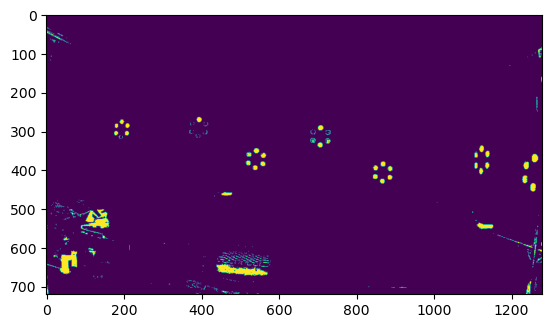

In [451]:
total_mask = gmask | rmask | bmask
plt.imshow(total_mask)
plt.show()

In [452]:
labels = label(total_mask)
regions = regionprops(labels)

In [453]:
# Filter based on size
regions = [
    item for item in regions
    if item.area_filled > 2
    and item.area_filled < 165
]

In [454]:
# Filter based on circle eccentricity
regions = [
    item for item in regions
    if item.eccentricity < 0.9
]

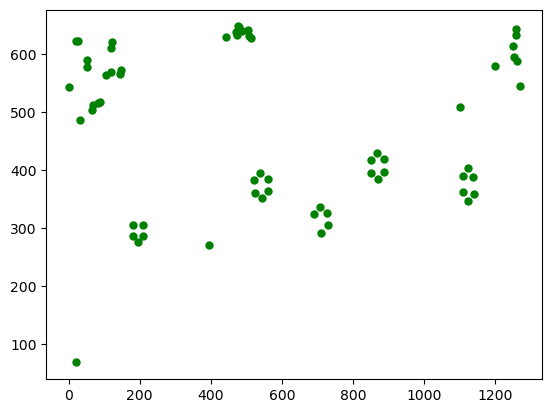

In [456]:
fig, ax = plt.subplots()
# ax.imshow(img, cmap=plt.cm.gray)
for i in range(len(regions)):
    y0, x0 = regions[i].centroid
    ax.plot(x0, y0, '.g', markersize=10)
plt.show()

In [457]:
centeroids = []
for props in regions:
    centeroids.append(props.centroid)

In [458]:
count = 0
points = []
targets = []
for point in centeroids:
    tree = KDTree(centeroids)
    points = []
    distances, indices = tree.query([point], k=6)
    for index in indices[0]:
        points.append(centeroids[index])
    a_points = np.array(points)
   
    ell = EllipseModel()
    ell.estimate(a_points)

    max_res = max(ell.residuals(a_points))
    if abs(max_res) < 0.2:
        targets.append(points)
        for point in points:
            centeroids.remove(point)
        
print(len(targets))

3


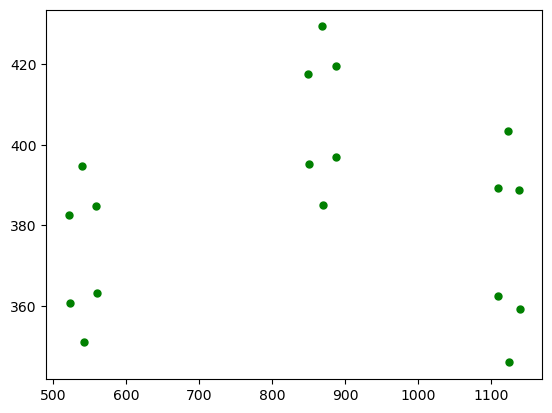

In [460]:
fig, ax = plt.subplots()
# ax.imshow(img, cmap=plt.cm.gray)
for target in targets:
    for point in target:
        y,x = point
        ax.plot(x, y, '.g', markersize=10)
plt.show()